## Visual Forensics: Deep Learning for Insurance Fraud Detection

***

This project focuses on detecting fraudulent vehicle insurance claims using computer vision techniques. Fraudulent claims can result in substantial financial losses for insurance companies and compromise the integrity of the claims process.

To address this issue, the project aims to develop an accurate and efficient image-based classification model capable of distinguishing between genuine and fake damage claims. Deep learning architectures such as EfficientNet and Convolutional Neural Networks (CNNs) will be explored to analyze visual patterns in vehicle damage. The evaluation of model performance will prioritize recall and precision to ensure high detection rates while minimizing false accusations. The solution is designed to assist insurance providers in automating claim verification, reducing processing time, improving fraud prevention, and enhancing overall operational integrity.

***

# Import Libraries

In [ ]:
import cv2
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ConvNeXtLarge, InceptionResNetV2, DenseNet201
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from tensorflow.keras.saving import register_keras_serializable

# Data Loading

Connecting Kaggle and Google Collaboratory

In [ ]:
# Create .kaggle folder and copy kaggle.json  files from Google Drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d pacificrm/car-insurance-fraud-detection

# Unzip file
!unzip -q car-insurance-fraud-detection.zip

# Define path
main_path = '/content/Insurance-Fraud-Detection/Insurance-Fraud-Detection/'

train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')
print("Train Images Folder:", train_path)
print("Test Images Folder:", test_path)

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/pacificrm/car-insurance-fraud-detection
License(s): CC0-1.0
 99% 818M/826M [00:00<00:00, 1.32GB/s]
100% 826M/826M [00:00<00:00, 1.36GB/s]
Train Images Folder: /content/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train
Test Images Folder: /content/Insurance-Fraud-Detection/Insurance-Fraud-Detection/test


In [ ]:
# Check how many data in `train_path` and `test_path`
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - Non-Fraud : 5000
Total Data - Fraud : 200

Test Path
Total Data - Non-Fraud : 1323
Total Data - Fraud : 93



From the results above, in the train path, the total fraud data is much less than non-fraud. This is an extreme imbalance that needs to be considered in building a model to avoid overfitting to the majority class.

# Exploratory Data Analysis

Class :  Non-Fraud


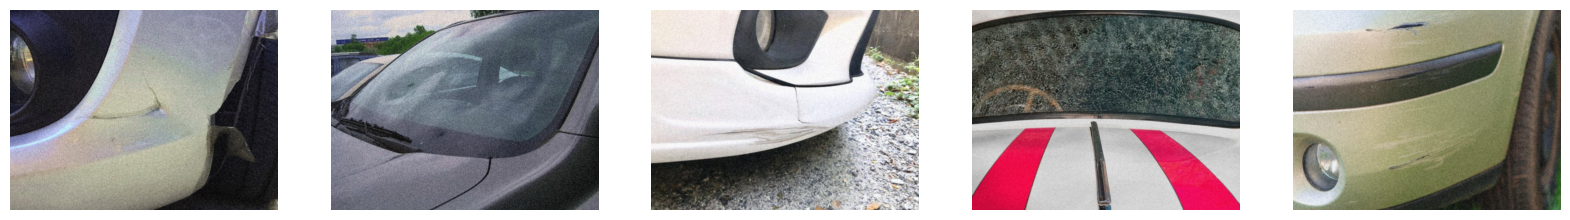

Class :  Fraud


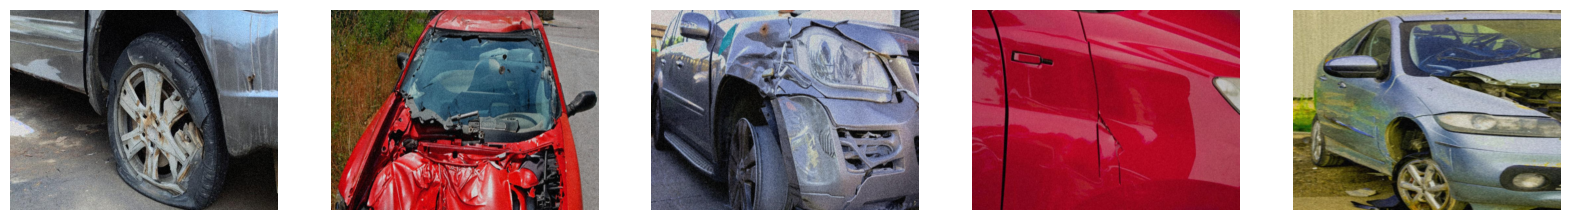

In [ ]:
# Function to visualize the first 5 images from each class
def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()
plot_images(train_path)

Class :  Non-Fraud


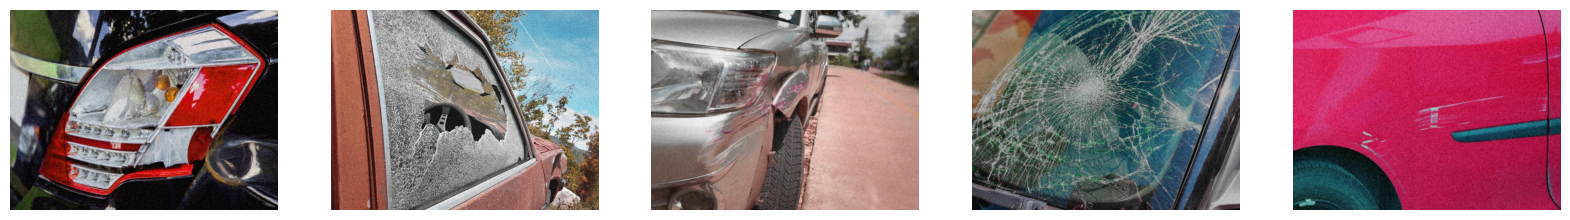

Class :  Fraud


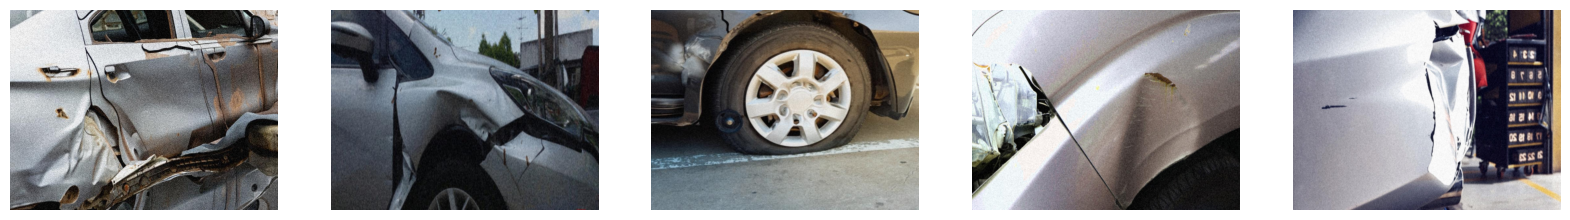

In [ ]:
plot_images(test_path)

In the Non-Fraud class, the visible damage is generally light to moderate, such as minor scratches, light dents, or cracked glass. This damage is normal and comparable to minor accidents or parking incidents, and occurs in a relatively small area. This indicates that insurance claims in this class tend to be authentic and in accordance with the type of damage that commonly occurs. The visualization shows that the car is still in good condition overall, with no signs of manipulation or suspicious extreme damage.

In contrast, in the Fraud class, the damage to the vehicle appears much more severe, including a destroyed car body, total tire damage, to severe damage that looks like a junk car. This damage covers a large area and sometimes appears disproportionate or out of context, thus raising an indication of potential over-claims or fraud. Some images even show the condition of the vehicle as if it has been completely damaged, which could be a signal of an intention to use insurance illegally.

# Feature Engineering

## Define classweights

After reviewing the data distribution in the data loading section, it was evident that the dataset suffers from a significant class imbalance, particularly due to the disproportionately small number of Fraud cases compared to Non-Fraud cases. To address this issue, a custom loss function called focal_loss is employed. This function is a modified version of binary cross-entropy that assigns greater weight to hard-to-classify examples.

The model encouraged to focus more on learning from the minority class, rather than being overly influenced by the dominant majority class. The focal_loss function is explicitly defined in Python and registered using the @register_keras_serializable() decorator. This ensures it can be seamlessly integrated as the loss parameter in model.compile()

In [ ]:
# Define focal loss function
@register_keras_serializable()
def focal_loss(gamma=2., alpha=0.25): # A higher value of gamma puts more focus on difficult samples. Alpha balances the importance between the two classes (e.g., more weight to the minority class).
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        focal_loss = -y_true * alpha * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred) \
                     - (1 - y_true) * (1 - alpha) * tf.math.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

The function works by first clipping the predicted probabilities to avoid numerical instability during logarithmic operations.Then it calculates the focal loss by assigning higher penalties to misclassified examples from the minority class. Using the alpha parameter to control class weighting and the gamma parameter to emphasize harder-to-classify instances.

This results in a loss value that down-weights easy examples and focuses training on challenging, underrepresented samples. Finally, the average loss across the batch is returned, guiding the model to learn more robustly from the minority class without being overwhelmed by the majority class.

## Preprocessing Process (splitting and Augmentating Images)

In [ ]:
# Create batch generator for train-set, val-set, and test-set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                validation_split=0.3,
                                                                rotation_range=10,         # Random image rotation ±10 degrees (Excessive rotation may affect data interpretation)
                                                                zoom_range=0.1,            # zoom in/out for size variation
                                                                horizontal_flip=True,      # To detect fraud, damage is not dependent on the side (The purpose is not insurance verification)
                                                                width_shift_range=0.1,     # Minor horizontal shifts for generalization of position
                                                                height_shift_range=0.1)    # Minor vertical shifts for generalization of position
                                                                # Not using shear range because it is not appropriate for the context. Because the damage can change drastically if sheared or rotated excessively.

# Validation data generator without augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(256,256),
                                              class_mode='binary', # Due to binary classificatoin
                                              subset='training',
                                              batch_size=32,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(256,256),
                                            class_mode='binary',# Due to binary classificatoin
                                            subset='validation',
                                            batch_size=32,
                                            shuffle=False,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(256,256),
                                            class_mode='binary', # Due to binary classificatoin
                                            batch_size=32,
                                            shuffle=False,
                                            seed=2)

Found 3640 images belonging to 2 classes.
Found 1560 images belonging to 2 classes.
Found 1416 images belonging to 2 classes.


# ANN Training (Sequential API)

## Model Definition

In [ ]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Build CNN model
model = Sequential()

# Block 1 (Input Layer)
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 2 (Hidden Layer)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 3 (Hidden Layer)
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Block 4 (Hidden Layer)
model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Reduce dimensions
model.add(GlobalAveragePooling2D()) # Using this rather than flatten to minimizes overfitting (especially important for imbalanced dataset).

# Fully Connected layers
model.add(Dropout(0.3)) # If the dropout is too high (ex: 0.5) it can hinder the learning process on unbalanced data.
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))  # Binary classification (fraud or non-fraud)

# Compile the model
model.compile(loss=focal_loss(),optimizer='adam',metrics=['accuracy',AUC(name='pr_auc', curve='PR')]) # Due to imbalance data, we use PR-AUC as metrics
model.summary()

# Handling Imbalanced Class
# Handle imbalanced class using Balanced Class Weighting by giving more weight to the minority class during training, so that the model “pays more attention” to the rare class without changing the amount of original data.
labels = train_set.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels),y=labels)
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

callbacks = [EarlyStopping(monitor='val_pr_auc', patience=5, restore_best_weights=True, mode='max'),ModelCheckpoint('/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/model.keras', monitor='val_loss', mode='min', save_best_only=True)]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,481 (2.00 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

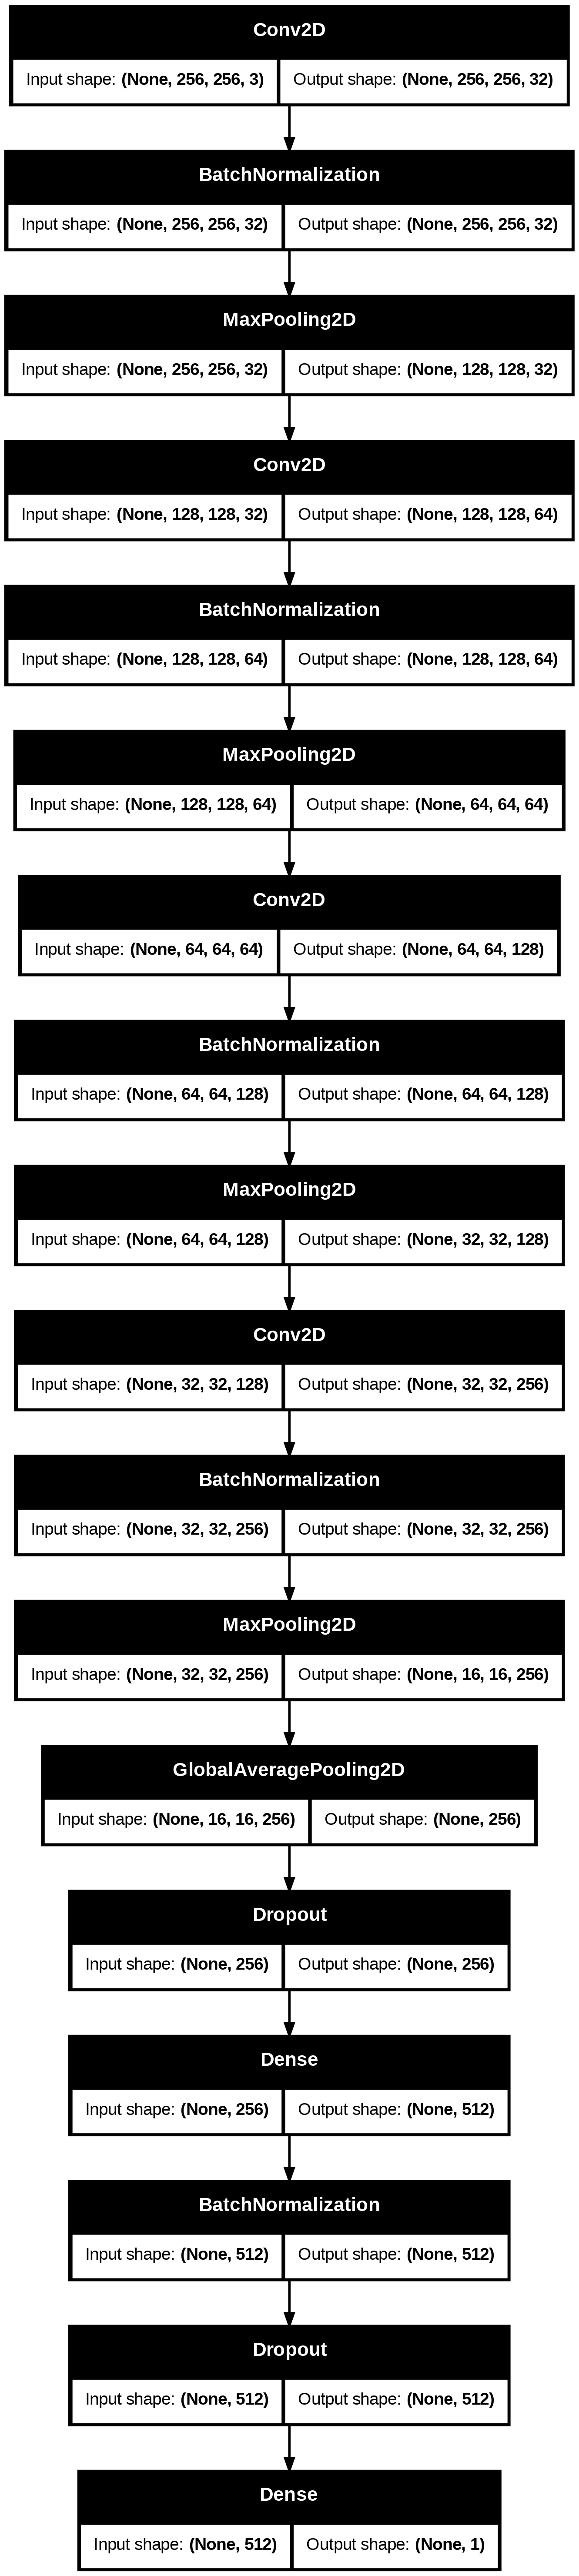

In [ ]:
# Plot layers
tf.keras.utils.plot_model(model, show_shapes=True)

This CNN architecture is carefully designed to handle image classification tasks under imbalanced conditions, such as fraud detection. The model using Sequential API, beginning with four convolutional blocks that progressively increase in filter size from 32 to 256, each followed by batch normalization and max pooling to stabilize and reduce spatial dimensions.

Instead of flattening the output which can lead to overfitting especially in imbalanced datasets. The model model uses GlobalAveragePooling2D which reduces parameters while preserving their information. The final layer uses a sigmoid activation for binary classification. To further enhance learning under class imbalance, the model is compiled with a custom focal_loss function, which dynamically focuses learning on difficult and underrepresented examples. Additionally, [Precision-Recall AUC](https://coralogix.com/ai-blog/ultimate-guide-to-pr-auc-calculations-uses-and-limitations/) is used as the primary metric due to its robustness in imbalanced settings. While class weighting is calculated and prepared using compute_class_weight. The model is supported with callbacks like early stopping and model checkpointing to preserve the best model and prevent overfitting during training.

# Model Training

In [ ]:
# Train the model
history = model.fit(train_set, epochs=30, validation_data=val_set, class_weight=class_weights_dict, callbacks=callbacks)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 128s 997ms/step - accuracy: 0.6630 - loss: 0.0997 - pr_auc: 0.9722 - val_accuracy: 0.9615 - val_loss: 0.0449 - val_pr_auc: 0.9691
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 96s 847ms/step - accuracy: 0.8144 - loss: 0.0673 - pr_auc: 0.9672 - val_accuracy: 0.9615 - val_loss: 0.0731 - val_pr_auc: 0.9756
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 92s 810ms/step - accuracy: 0.8515 - loss: 0.0718 - pr_auc: 0.9630 - val_accuracy: 0.9615 - val_loss: 0.0539 - val_pr_auc: 0.9740
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 92s 811ms/step - accuracy: 0.8754 - loss: 0.0400 - pr_auc: 0.9798 - val_accuracy: 0.9519 - val_loss: 0.0352 - val_pr_auc: 0.9750
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 91s 796ms/step - accuracy: 0.8701 - loss: 0.0376 - pr_auc: 0.9802 - val_accuracy: 0.9609 - val_loss: 0.0285 - val_pr_auc: 0.9803
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 822ms/step - accuracy: 0.8858 - loss: 0.0377 - pr_auc: 0.9754 - val_accuracy: 0.9192 - val_loss: 0.0327 - val_

# Model Evaluation

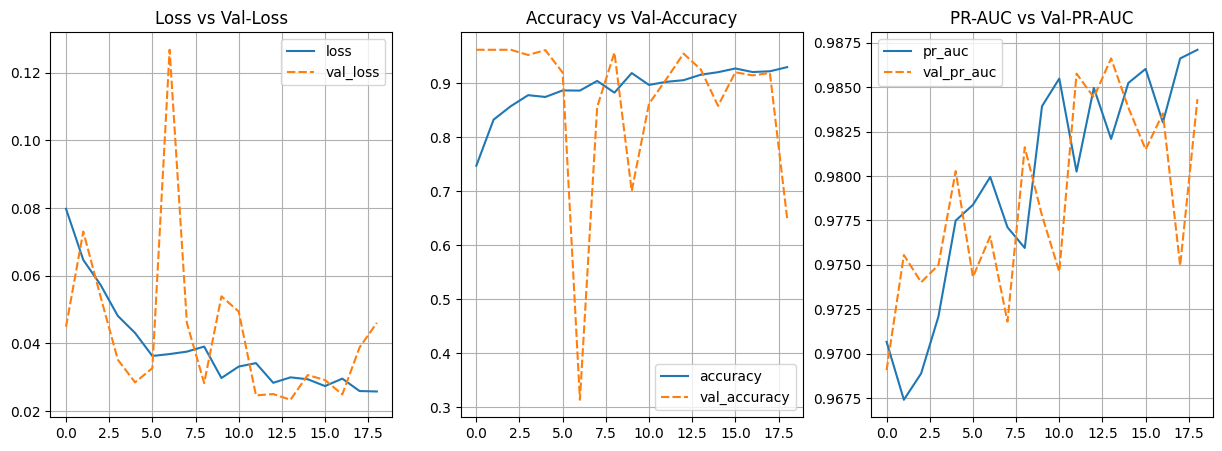

In [ ]:
# Plot training results
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 3, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 3, 3)
sns.lineplot(data=history_df[['pr_auc', 'val_pr_auc']])
plt.grid()
plt.title('PR-AUC vs Val-PR-AUC')
plt.show()

In this case we're using F1-score as thresholds to determine the optimal classification threshold because it balances precision and recall, which is crucial in insurance fraud detection. Predicting a fraudulent claim correctly (true positive) is valuable for reducing financial loss, but falsely flagging genuine claims (false positives) can reduce customer trust.

A high precision minimizes false positives, while high recall ensures most fraud cases are caught. Since both are important, F1-score serves as a harmonic mean that captures this trade-off. This threshold tuning helps make the model both effective and fair in a high-stakes business application.

So, we're using same thresholds (F1-Score) for evaluation on this model and model improvement using transfer learning.

In [ ]:
# Take the predicted probability from val_set
X_val = []
y_val = []

for i in range(len(val_set)):
    x_batch, y_batch = val_set[i]
    X_val.append(x_batch)
    y_val.append(y_batch)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Probability prediction
y_pred_prob = model.predict(X_val).ravel()

# Calculate Average Precision score (PR-AUC)
pr_auc = average_precision_score(y_val, y_pred_prob)

# Calculate Precision, Recall, and threshold of probability
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

# Calculate F1-score every threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Best Threshold based on F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Get the probability
y_pred_prob = model.predict(test_set)

# Apply custom threshold to get predicted classes
y_pred_class = (y_pred_prob.ravel() >= best_threshold).astype(int)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class,
                            target_names=np.array(list(train_set.class_indices.keys()))))
print(f"PR-AUC (Average Precision Score) : {pr_auc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step
              precision    recall  f1-score   support

       Fraud       0.00      0.00      0.00        93
   Non-Fraud       0.93      1.00      0.97      1323

    accuracy                           0.93      1416
   macro avg       0.47      0.50      0.48      1416
weighted avg       0.87      0.93      0.90      1416

PR-AUC (Average Precision Score) : 0.9865


PR-AUC score of 0.9865, the model shows a strong ability to distinguish between Fraud and Non-Fraud classes. The accuracy of 0.93 suggest that the model performs well overall. However, the model completely fails to identify the Fraud class, with precision, recall, and F1-score all at 0.00. This stark disparity suggests that the model is highly biased toward the majority class and severely underfits the minority class.

Given these results, the model can be characterized as a underfit on the minority class. It captures the overall distribution well but does not yet learn enough features to detect complex patterns in the Fraud class. It uisually happens when training from scratch on a relatively small dataset or a dataset lacking sufficient variation in minority examples.

# ANN Improvement (Functional API)

## Transfer Learning

The previous model had limitations that explained in the previous section. To address this limitation, transitioning to transfer learning by using pretrained convolutional neural networks such as [ConvNeXtLarge](https://keras.io/api/applications/convnext/), [InceptionResNetV2](https://keras.io/api/applications/inceptionresnetv2/) and [DenseNet201](https://keras.io/api/applications/densenet/) leverage features learned from large-scale datasets (ImageNet). These features generalize well to a wide range of vision tasks and often accelerate convergence and improve performance, especially when labeled data is limited or imbalanced.

## Load Pre-trained Model

ConvNeXtLarge

In [ ]:
# Load pre-trained ConvNeXtLarge
pretrained_convnext = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
pretrained_convnext.trainable = False  # Freeze the model layers

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step


InceptionResNetV2

In [ ]:
# Load pre-trained InceptionResNetV2
pretrained_inception = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
pretrained_inception.trainable = False  # Freeze the model layers

## Model Definition

ConvNeXtLarge

In [ ]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Build Functional API
x = pretrained_convnext.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model_convnext = Model(pretrained_convnext.input, outputs=output)

# Compile model
model_convnext.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=['accuracy',AUC(name='pr_auc', curve='PR')])
model_convnext.summary()

# Class weights for imbalance class
labels = train_set.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Callbacks
callbacks = [EarlyStopping(monitor='val_pr_auc', patience=5, restore_best_weights=True, mode='max'),
             ModelCheckpoint('/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/convnext.keras', monitor='val_pr_auc', save_best_only=True, mode='max')]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_pre… │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_stem │ (None, 64, 64,    │      9,792 │ convnext_large_p… │
│ (Sequential)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │      9,600 │ convnext_large_s… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │        384 │ convnext_large_s… │
│ (LayerNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │    148,224 │ convnext_large_s… │
│ (Dense)             │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │          0 │ convnext_large_s… │
│ (Activation)        │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │    147,648 │ convnext_large_s… │
│ (Dense)             │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │        192 │ convnext_large_s… │
│ (LayerScale)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │          0 │ convnext_large_s… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ convnext_large_s… │
│                     │ 192)              │            │ convnext_large_s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │      9,600 │ add[0][0]         │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │        384 │ convnext_large_s… │
│ (LayerNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │    148,224 │ convnext_large_s… │
│ (Dense)             │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │          0 │ convnext_large_s… │
│ (Activation)        │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │    147,648 │ convnext_large_s… │
│ (Dense)             │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_large_sta… │ (None, 64, 64,    │        192 │ convnext_large_s

 Total params: 197,017,793 (751.56 MB)

 Trainable params: 787,457 (3.00 MB)

 Non-trainable params: 196,230,336 (748.56 MB)

InceptionResNetV2

In [ ]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Build Functional API
x = pretrained_inception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)

model_inception = Model(pretrained_inception.input, outputs=output)

# Compile model
model_inception.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=3.0, alpha=0.5),
    metrics=['accuracy',AUC(name='pr_auc', curve='PR')])
model_inception.summary()

# Class weights for imbalance class
labels = train_set.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Callbacks
callbacks = [EarlyStopping(monitor='val_pr_auc', patience=5, restore_best_weights=True, mode='max'),
             ModelCheckpoint('/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/inception.keras', monitor='val_pr_auc', save_best_only=True, mode='max')]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 55,124,193 (210.28 MB)

 Trainable params: 31,586,721 (120.49 MB)

 Non-trainable params: 23,537,472 (89.79 MB)

## Model Training

ConvNeXtLarge

In [ ]:
# Training
history_convnext = model_convnext.fit(train_set,epochs=30,validation_data=val_set,class_weight=class_weights_dict,callbacks=callbacks)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.8227 - loss: 0.0734 - pr_auc: 0.9554 - val_accuracy: 0.9532 - val_loss: 0.0224 - val_pr_auc: 0.9829
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8624 - loss: 0.0399 - pr_auc: 0.9792 - val_accuracy: 0.9494 - val_loss: 0.0213 - val_pr_auc: 0.9867
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8744 - loss: 0.0363 - pr_auc: 0.9796 - val_accuracy: 0.9577 - val_loss: 0.0200 - val_pr_auc: 0.9885
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8892 - loss: 0.0391 - pr_auc: 0.9759 - val_accuracy: 0.9551 - val_loss: 0.0193 - val_pr_auc: 0.9897
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8968 - loss: 0.0381 - pr_auc: 0.9746 - val_accuracy: 0.9545 - val_loss: 0.0194 - val_pr_auc: 0.9894
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8971 - loss: 0.0388 - pr_auc: 0.9756 - val_accuracy: 0.9500 - val_loss: 0.0195 - val_pr_auc: 0.989

InceptionResNetV2

In [ ]:
# Training
history_inception = model_inception.fit(train_set, epochs=30, validation_data=val_set, class_weight=class_weights_dict, callbacks=callbacks)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8782 - loss: 0.0591 - pr_auc: 0.9683 - val_accuracy: 0.9609 - val_loss: 0.0105 - val_pr_auc: 0.9877
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 816ms/step - accuracy: 0.9287 - loss: 0.0244 - pr_auc: 0.9773 - val_accuracy: 0.9667 - val_loss: 0.0101 - val_pr_auc: 0.9884
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 818ms/step - accuracy: 0.9466 - loss: 0.0165 - pr_auc: 0.9860 - val_accuracy: 0.9571 - val_loss: 0.0097 - val_pr_auc: 0.9917
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 822ms/step - accuracy: 0.9271 - loss: 0.0244 - pr_auc: 0.9761 - val_accuracy: 0.9622 - val_loss: 0.0095 - val_pr_auc: 0.9924
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 820ms/step - accuracy: 0.9480 - loss: 0.0142 - pr_auc: 0.9912 - val_accuracy: 0.9635 - val_loss: 0.0094 - val_pr_auc: 0.9917
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 821ms/step - accuracy: 0.9567 - loss: 0.0131 - pr_auc: 0.9899 - val_accuracy: 0.9615 - val_loss: 0.0099 - val_pr_

## Model Evaluation

ConvNeXtLarge

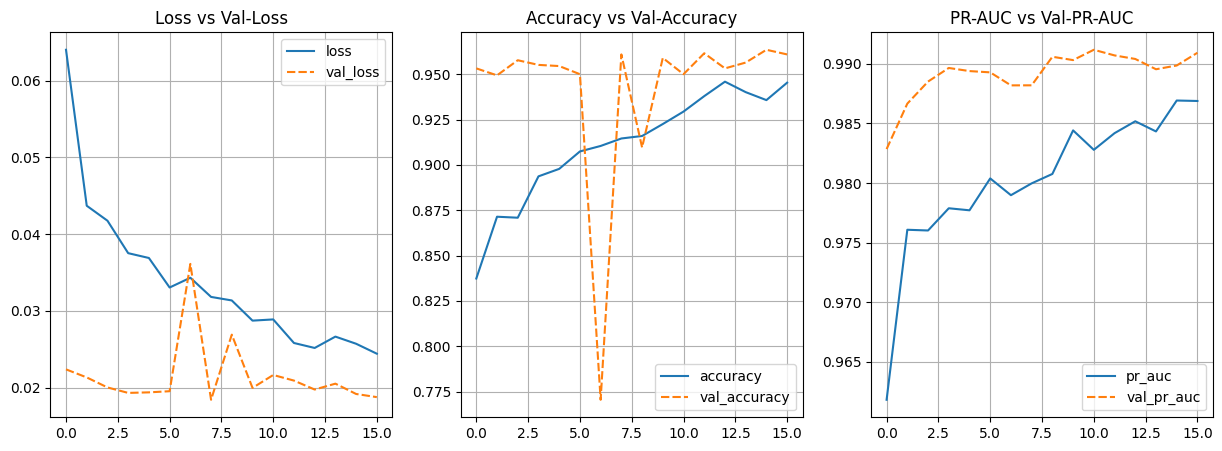

In [ ]:
# Plot training results
history_convnext_df = pd.DataFrame(history_convnext.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_convnext_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 3, 2)
sns.lineplot(data=history_convnext_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 3, 3)
sns.lineplot(data=history_convnext_df[['pr_auc', 'val_pr_auc']])
plt.grid()
plt.title('PR-AUC vs Val-PR-AUC')
plt.show()

In [ ]:
# Take the predicted probability from val_set
X_val = []
y_val = []

for i in range(len(val_set)):
    x_batch, y_batch = val_set[i]
    X_val.append(x_batch)
    y_val.append(y_batch)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Probability prediction
y_pred_prob = model_convnext.predict(X_val).ravel()

# Calculate Average Precision score (PR-AUC)
pr_auc = average_precision_score(y_val, y_pred_prob)

# Calculate Precision, Recall, and threshold of probability
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

# Calculate F1-score every threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Best Threshold based on F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Get the probability
y_pred_prob = model_convnext.predict(test_set)

# Apply custom threshold to get predicted classes
y_pred_class = (y_pred_prob.ravel() >= best_threshold).astype(int)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class,
                            target_names=np.array(list(train_set.class_indices.keys()))))
print(f"PR-AUC (Average Precision Score) : {pr_auc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 975ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 917ms/step
              precision    recall  f1-score   support

       Fraud       0.61      0.12      0.20        93
   Non-Fraud       0.94      0.99      0.97      1323

    accuracy                           0.94      1416
   macro avg       0.78      0.56      0.58      1416
weighted avg       0.92      0.94      0.92      1416

PR-AUC (Average Precision Score) : 0.9907


This model demonstrates strong overall performance, particularly in handling the class imbalance. With a high PR-AUC of 0.9907 and excellent performance on the majority class (Non-Fraud), it effectively distinguishes between relevant and irrelevant cases. However, the low recall (0.12) and F1-score (0.20) for the minority class (Fraud) indicate that the model still struggles to correctly identify a significant portion of fraudulent cases.

InceptionResNetV2

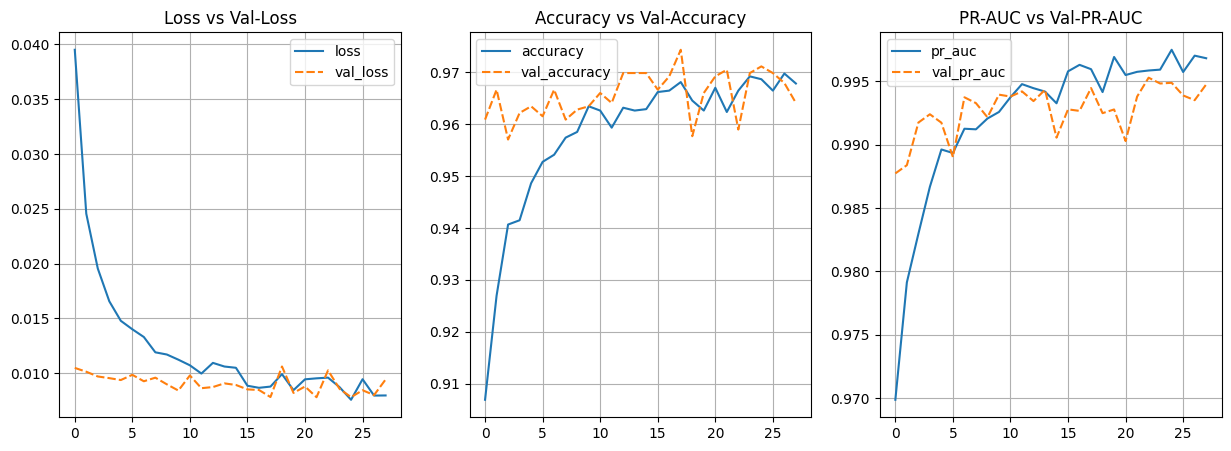

In [ ]:
# Plot training results
history_inception_df = pd.DataFrame(history_inception.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_inception_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 3, 2)
sns.lineplot(data=history_inception_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 3, 3)
sns.lineplot(data=history_inception_df[['pr_auc', 'val_pr_auc']])
plt.grid()
plt.title('PR-AUC vs Val-PR-AUC')
plt.show()

In [ ]:
# Take the predicted probability from val_set
X_val = []
y_val = []

for i in range(len(val_set)):
    x_batch, y_batch = val_set[i]
    X_val.append(x_batch)
    y_val.append(y_batch)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Probability prediction
y_pred_prob = model_inception.predict(X_val).ravel()

# Calculate Average Precision score (PR-AUC)
pr_auc = average_precision_score(y_val, y_pred_prob)

# Calculate Precision, Recall, and threshold of probability
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

# Calculate F1-score every threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Best Threshold based on F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Get the probability
y_pred_prob = model_inception.predict(test_set)

# Apply custom threshold to get predicted classes
y_pred_class = (y_pred_prob.ravel() >= best_threshold).astype(int)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class,
                            target_names=np.array(list(train_set.class_indices.keys()))))
print(f"PR-AUC (Average Precision Score) : {pr_auc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 429ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step
              precision    recall  f1-score   support

       Fraud       0.75      0.49      0.60        93
   Non-Fraud       0.97      0.99      0.98      1323

    accuracy                           0.96      1416
   macro avg       0.86      0.74      0.79      1416
weighted avg       0.95      0.96      0.95      1416

PR-AUC (Average Precision Score) : 0.9930


This model shows a significant improvement in detecting Fraud cases, with recall increasing from 0.12 to 0.49 and F1-score from 0.20 to 0.60 indicating better sensitivity to the minority class. While maintaining strong performance on Non-Fraud cases (precision 0.97, recall 0.99), the model now achieves better balance between classes. The macro average F1-score rose from 0.58 to 0.79, and the PR-AUC slightly improved from 0.9907 to 0.9930, confirming that the model not only maintains its ability to rank predictions well but also learns more meaningful patterns in Fraud detection, making it significantly more reliable for real-world deployment. So we're using this model for [fine-tune](https://www.tensorflow.org/tutorials/images/transfer_learning) improvement. Basically, were only training a few layers on top of an InceptionResNetV2 base model. The weights of the pre-trained network were not updated during training.

## Fine-Tune

InceptionResNetV2

In [ ]:
# Unfreeze some layers for fine-tuning
fine_tune_at = int(0.6 * len(pretrained_inception.layers))  # Freeze 60%

for layer in model_inception.layers[:fine_tune_at]:
    layer.trainable = False # Freeze 60% layer
for layer in model_inception.layers[fine_tune_at:]:
    layer.trainable = True # Unfreeze 40%

# Compile Model
model_inception.compile(loss=focal_loss(), optimizer=Adam(learning_rate=5e-6), metrics=['accuracy',AUC(name='pr_auc', curve='PR')])
model_inception.summary()

# Callbacks
callbacks = [EarlyStopping(monitor='val_pr_auc', patience=3, restore_best_weights=True, mode='max'),
             ModelCheckpoint('/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/fine_tune.keras', monitor='val_pr_auc', mode='max', save_best_only=True),
             ReduceLROnPlateau(monitor='val_pr_auc', factor=0.1, patience=2,min_lr=1e-6, mode='max')]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 55,124,193 (210.28 MB)

 Trainable params: 37,078,017 (141.44 MB)

 Non-trainable params: 18,046,176 (68.84 MB)

In [ ]:
# Training
history_finetune = model_inception.fit(train_set,epochs=30,validation_data=val_set,class_weight=class_weights_dict,callbacks=callbacks)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9698 - loss: 0.0110 - pr_auc: 0.9988 - val_accuracy: 0.9705 - val_loss: 0.0223 - val_pr_auc: 0.9911 - learning_rate: 5.0000e-06
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 95s 834ms/step - accuracy: 0.9707 - loss: 0.0081 - pr_auc: 0.9992 - val_accuracy: 0.9641 - val_loss: 0.0212 - val_pr_auc: 0.9911 - learning_rate: 5.0000e-06
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 96s 844ms/step - accuracy: 0.9729 - loss: 0.0078 - pr_auc: 0.9992 - val_accuracy: 0.9692 - val_loss: 0.0192 - val_pr_auc: 0.9913 - learning_rate: 5.0000e-06
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 95s 832ms/step - accuracy: 0.9861 - loss: 0.0049 - pr_auc: 0.9997 - val_accuracy: 0.9654 - val_loss: 0.0209 - val_pr_auc: 0.9920 - learning_rate: 5.0000e-06
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 96s 841ms/step - accuracy: 0.9777 - loss: 0.0069 - pr_auc: 0.9997 - val_accuracy: 0.9596 - val_loss: 0.0193 - val_pr_auc: 0.9935 - learning_rate: 5.0000e-06
Epoch 6/30
114/11

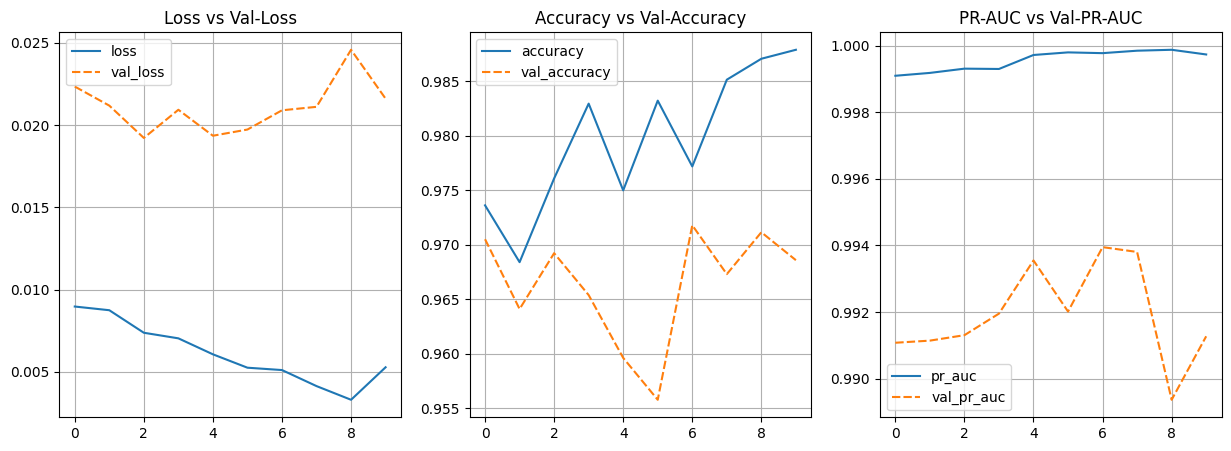

In [ ]:
# Plot training results
history_tuned_df = pd.DataFrame(history_finetune.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_tuned_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 3, 2)
sns.lineplot(data=history_tuned_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 3, 3)
sns.lineplot(data=history_tuned_df[['pr_auc', 'val_pr_auc']])
plt.grid()
plt.title('PR-AUC vs Val-PR-AUC')
plt.show()

In [ ]:
# Take the predicted probability from val_set
X_val = []
y_val = []

for i in range(len(val_set)):
    x_batch, y_batch = val_set[i]
    X_val.append(x_batch)
    y_val.append(y_batch)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Probability prediction
y_pred_prob = model_inception.predict(X_val).ravel()

# Calculate Average Precision score (PR-AUC)
pr_auc = average_precision_score(y_val, y_pred_prob)

# Calculate Precision, Recall, and threshold of probability
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

# Calculate F1-score every threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Best Threshold based on F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Get the probability
y_pred_prob = model_inception.predict(test_set)

# Apply custom threshold to get predicted classes
y_pred_class = (y_pred_prob.ravel() >= best_threshold).astype(int)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class,
                            target_names=np.array(list(train_set.class_indices.keys()))))
print(f"PR-AUC (Average Precision Score) : {pr_auc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 408ms/step
              precision    recall  f1-score   support

       Fraud       0.89      0.59      0.71        93
   Non-Fraud       0.97      0.99      0.98      1323

    accuracy                           0.97      1416
   macro avg       0.93      0.79      0.85      1416
weighted avg       0.97      0.97      0.97      1416

PR-AUC (Average Precision Score) : 0.9884


This improved fine-tuned InceptionResNetV2 model shows further progress, especially in detecting Fraud cases. The recall for Fraud increased from 0.49 to 0.59, and the F1-score rose from 0.60 to 0.71, indicating stronger detection capability on the minority class without sacrificing performance on Non-Fraud (which remains excellent with 0.97 precision and 0.99 recall). Although the PR-AUC slightly decreased from 0.9930 to 0.9884, this is still exceptionally high and reflects strong ranking performance. Overall, this version of the model demonstrates better balance and generalization across both classes, suggesting that the additional fine-tuning has successfully enhanced its real-world applicability for fraud detection.

# Model Saving

In [ ]:
model_inception.save('/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/model.keras')

In [ ]:
with open('/content/drive/My Drive/p2-ftds027-hck-g7-farrashv8/best_threshold', 'w') as f:
    json.dump({'threshold': float(best_threshold)}, f)

# Model Advantages and disadvantages Explanation

- Base CNN model.

  - Advantages :
  
    - Simpler architecture and faster training time, which makes it easier to deploy in resource-constrained environments.

    - Less prone to overfitting on small datasets due to its lower capacity.

  - Disadvantages :

    - Struggles to learn complex visual patterns needed for nuanced fraud detection, especially under class imbalance.

    - Lower recall on fraudulent cases, indicating difficulty in capturing rare patterns that distinguish fake claims from genuine ones.

    - Limited generalization on real-world variations like lighting, angle, or damage severity.

- ConvNeXtLarge

  - Advantages :

    - Superior feature extraction and representation capabilities and excels at capturing fine-grained details and complex textures in high-resolution damage images.

    - High recall and F1-score on fraud class, suggesting strong sensitivity to subtle or manipulated damage patterns.

  - Disadvantages :

    - Requires significantly more computational resources and memory, making it harder to scale or deploy without powerful hardware.

    -  Overfitting risk if not fine-tuned carefully, especially on imbalanced datasets.

- InceptionResNetV2

  - Advantages :

    - Balances performance and efficiency well—high accuracy and recall, even on imbalanced datasets.

    - Fine-tuning improves its focus on the minority class, making it highly reliable in detecting fraudulent cases without sacrificing performance on genuine claims.

  - Disadvantages :

    - Larger than a basic CNN, which means longer training and inference time compared to simpler architectures and slightly less robust to noisy labels.

